In [12]:
import pandas as pd
from scipy.io import loadmat

In [1]:
import numpy as np
from scipy.optimize import fmin_cg

def sigmoid(X):
    """
    It returns the sigmoid function applied to the matrix X. X may have any shape.
    """
    sig = 1/(1+np.exp(-X))
    return sig

def sigmoidGradient(X):
    """
    It returns the derivative of the sigmoid function calculated at X. X is a matrix and may have any shape.
    """
    sig_g = sigmoid(X)*(1-sigmoid(X))
    return sig_g

def Rand_param_Theta(In_value, Out_value):
    """
    It returns a (Out_value x In_value+1) random matrix with small entries.
    """
    epsilon_init = 0.12
    Rand_param = np.random.rand(Out_value, In_value+1) * 2 * epsilon_init - epsilon_init
    return Rand_param


def nn_predict(nn_params, layers_data, X, min_class_pred = 0):
    """
    The function returns a vector with the classification prediction for the set X.
    min_class_pred identify the smaller integer in the classification and must be adjusted accordingly to your
    classification labels. For instance if your labels are 1-10 you need to set min_class_pred =1. This is because
    the predictions are obtained from the indeces of a matrix and python as base index 0. By default it is setted
    on zero.
    """
    Theta_vec = reshape_thetas(nn_params, layers_data) 
    m = np.shape(X)[0]
    h_pred = [0 for i in range(len(Theta_vec)+1)]
    h_pred[0] = np.hstack((np.ones(m)[np.newaxis].T, X))
    for i in range(len(h_pred)-1):
        h = sigmoid(h_pred[i]@Theta_vec[i].T)
        if i == len(h_pred)-2:

            h_pred[i+1] = h                                           # h_pred[-1] is a (num_exp x num_label) matrix. The entry (i,j) contains the probabilities
                                                                      # that the i-th experiment is classified with label j
        else:
            h_pred[i+1] = np.hstack((np.ones(m)[np.newaxis].T, h))

    return np.argmax(h_pred[-1],axis = 1)+min_class_pred

def nn_score(nn_params, hidden_layer_sizes, X, Y):
    """
        It return the accuracy of the Neural Network given the parameter vector nn_params, the expereiments matrix X
        and the label vector Y.
    """
    input_layer_size = np.shape(X)[1]        #recovering the input units from the experimental matrix
    num_labels = len(np.unique(Y))           #recovering the number of labels from the data stored in the label vector Y
    layers_data = [input_layer_size] + hidden_layer_sizes + [num_labels]         # a vector that contains the info about the units of all the layers
    min_class_pred = np.unique(Y)[0]

    pred =  nn_predict(nn_params, layers_data, X, min_class_pred)
    if np.ndim(Y) ==1: Y[np.newaxis]
    if np.shape(Y)[1] == 1:
        Y = Y.T                                         # Reshape Y in a row vector in order to perform boolean operation

    return(pred == Y).mean()

def reshape_thetas(nn_params,layers_data):
    """
    Given a vector v and a list of integers L of lenght n it will returns a list of n-1 matrices exatrapolated by the vector v.
    The shape of a returned matrix is (j x (i+1)) where [...,i,j,..] are two consecutive entries of the list L.
    If it will not be possible automatically rise an Error. The order to reshape the matrices is F = Fortran.
    """
    T_list = []
    start_ind = 0
    for m,n in zip(layers_data,layers_data[1:]):
        dum = np.reshape(nn_params[start_ind:start_ind+n*(m+1)], (n, m+1), order = 'F')
        T_list.append(dum)
        start_ind = start_ind + n*(m+1)
    return T_list

def  ForwardProp(nn_params, layers_data, X, Y, class_range = [0,1]):
    """
    It compute the Forward Propagation of the Neural Network.
    It returns
            -a_vec : a vector containing the computed value of the units for each layer.
                    Therefore a_vec[0] are the input units + bias, while a_vec[-1] are
                    the outputs units without the bias to use in the activation function.

           - z_vec : contains the values of the activation function at each unit of the layer
                     excluded the output ones.

           - Y : is a label Matrix of zeroes and ones. Column j has value 1 in i-th position
                 if i is the value of the j-th entries of Y. If it is not a "row" vector it will
                 be reshape into one

           - Theta_vec : is the list of the weights matrices.
    """
                ### UTILITIES ###
    Theta_vec = reshape_thetas(nn_params, layers_data)                 # recover the weights matrices from the weights vector

    m = np.shape(X)[0]                                                 # number of experiments
    min_class = class_range[0]                                         # smallest value occurring in the classification
    max_class = class_range[-1]                                        # larger alue occurring in the classification

                ### CLASSIFICATION MATRIX ###
    I = np.repeat([np.arange(min_class, max_class +1)],m,0).T          # Classification Matrix
    if np.ndim(Y) == 1:
        Y = Y[np.newaxis]
    if np.shape(Y)[1] == 1:
        Y = Y.T                                          # Reshape Y in a row vector in order to perform boolean operation

    Y = np.array(I == Y).astype(int)                                   # Matrix of zeroes and ones of the labels. Column j has value 1 in i-th position if i is the value of the j-th entries of Y. 


    ### FORWARD ROPAGATION ###
    J = 0                                                  # Initialise the cost Function J
    a1 = np.hstack((np.ones(m)[np.newaxis].T, X))          # Add the bias Column at the Input Layer
    a_vec = [0 for i in range(len(layers_data))]           # Initialise the units vector
    z_vec = [0 for i in range(len(layers_data)-1)]         # Initialise the activation function vector
    a_vec[0] = a1.T

    for i in range(len(layers_data)-1):
        zi = Theta_vec[i]@a_vec[i]                  # comupte z(i)
        z_vec[i] = zi
        ai = sigmoid(zi)                            # Values of the unit at layer (i)
        mi = np.shape(ai)[1]
        if i != len(layers_data)-2:
            a_i_bias = np.vstack((np.ones(mi), ai)) # Add the Bias Column at the units
            a_vec[i+1] = a_i_bias
        else:
            a_vec[i+1] = ai

    return a_vec, z_vec, Y,Theta_vec


def cost_func_NN(nn_params, layers_data, X, Y, class_range = [0,1], Lambda =0):
    """
      The function has input:
        - nn params  : a vector of weights parameters
        - layers_data: a list containing the number of units at each layer (input and output included)
        - X : the training set matrix X
        - Y : the label vector Y
        -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                 The maximum value determines also how many values the Neural Network need to
                                 classify. By default it is setted as a binary 0,1 classifier.
        - J : the regularisation parameter, by default is zero
     The algorithm is vectorised and will return the value of the cost function J on the output layer.
    """

    m = np.shape(X)[0]
    a,_,Y,Theta_vec = ForwardProp(nn_params, layers_data, X, Y, class_range)   #computing the units values, the label matrix Y and the weights matrices
    a_out = a[-1]  # the output units of the Neural Network

    reg = (Lambda/(2*m))*(sum([(Theta[:,1:]*Theta[:,1:]).sum() for Theta in Theta_vec])) #regolarisation factor

    J = (1/m) * (((-Y * np.log(a_out))-((1-Y) * np.log(1-a_out))).sum()) + reg           #formula for the regularised cost function

    return(J)



def grad_NN(nn_params,layers_data, X, Y, class_range = [0,1], Lambda =0):
    """
    It compute the Backward Propagation and gradient of the Neural Network.
    The function as input
        - nn params  : a vector of weights parameters
        - layers_data: a list containing the number of units at each layer (input and output included)
        - X : the training set matrix X
        - Y : the label vector Y
        -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                 The maximum value determines also how many values the Neural Network need to
                                 classify. By default it is setted as a binary 0,1 classifier.
        - Lambda : the regularisation parameter, by default is zero
   The output is a single vector containing all the unrolled gradients. This is because the fmin_cg accept
   only vectors and not matrices.
   """
    m = np.shape(X)[0]
    a_vet,z,Y,Theta_vec = ForwardProp(nn_params, layers_data, X, Y, class_range)  #computing the units values, the activated values z, the label matrix Y and the weights matrices

    delta = [0 for i in range(len(layers_data)-1)]                   # initialise the little delta list
    for i in reversed(range(1,len(layers_data))):
        if i == len(layers_data)-1:
            delta[i-1] = a_vet[-1]-Y                                # this is the value of the delta_out
        else:
            delta[i-1]= (Theta_vec[i][:,1:].T@delta[i])*sigmoidGradient(z[i-1]) #formula for computing the inner delta.

    Delta = [0 for i in range(len(layers_data)-1)]        # Initialise the big delta list. 
    for i in reversed(range(0, len(layers_data)-1)):
        Delta[i] = delta[i]@a_vet[i].T                      # The entry i is a matrix with same shape of the weights matrix i

    reg_grad = [(Lambda/m)*(np.hstack((np.zeros(np.shape(Theta)[0])[np.newaxis].T, Theta[:,1:]))) for Theta in Theta_vec] #regularisation factors
    Theta_grad =[(1/m)*Del+reg for Del,reg in zip(Delta,reg_grad)]                     # list of gradient matrices
    grad_vec = np.concatenate([Theta_g.reshape(Theta_g.size,order = 'F') for Theta_g in Theta_grad]) #gradients vector

    return grad_vec


def mini_batches(X,Y, num_batches = 1, strict_num_batches = True):
    """
        The function will divides the trainining and labels sets into mini batches.
        The output is a list containing the mini batches and their respictevely labels.
        It takes input

            -X : is a training matrix. Each row is an experiment and each column is a feature.

            -Y : is a vector containing the labels of the experiments.

            -num_batches (optional): it is the number of mini batch you want create. By defaul
                                     it is 1, so tat it returns the entire training and label set

            -strict_num_batches(optional): if the required number of mini_batches does not split
                                           the training when True it will return num_batches mini 
                                           batches with the last one bigger since contains the remaining
                                           value of X. If False it return num_batches+1 mini batches
                                           with the first num_batches dimensionally equals.
    """

    if num_batches == 1:
        return [(X,Y)]
    else:
        ### INITIALISATION ###
        m = np.shape(X)[0]                  # Number of training examples
        if np.ndim(Y) ==1: Y[np.newaxis]    # we need to see a vector as a mx1 or 1xm matrix to perform the transpose
        if np.shape(Y)[1] != 1:             # Y must be a column vector
            Y = Y.T
        full_data = np.hstack((X,Y))
        np.random.shuffle(full_data)
        batch_size = m // num_batches      # it returns the floor of m/num_batches
        batches = [0 for i in range(num_batches)]

        if m % num_batches ==0: 
            creation_iter = num_batches
            flag = False
        else: 
            creation_iter = num_batches +1
            flag = True

            ### BATCHES CREATION ###
        for i in range(creation_iter):
            batch_i = full_data[i*batch_size:(i+1)*batch_size,:]
            X_i = batch_i[:,:-1]
            Y_i = batch_i[:,-1]

            if flag:
                if strict_num_batches and i+1 == num_batches:    # if the number of batches does not split perfectly the training set
                    batch_i = full_data[i*batch_size:,:]         # then the last batch it will contains all the remaining values and 
                    X_i = batch_i[:,:-1]                         # the function it will return a list with num_batches entries
                    Y_i = batch_i[:,-1]
                    batches[i] = X_i,Y_i
                    break
                elif i == num_batches:                           # if the number of batches does not split perfectly the training set
                    batches.append((X_i,Y_i))                    # then the function it will return a list with num_batches+1 entries
                    break                                        # with the first num_batches will be dimensional equal.

            batches[i] = X_i,Y_i

        return batches


def grad_descent(nn_params, layers_data, X, Y, n_iters = 100, class_range = [0,1], learning_rate = 0.001, momentum = 0, Lambda = 0, num_batches = 1, strict_num_batches = True, verbose = True, SGD_history = False):
    """
        Perform the Gradient descent Algorithm(s). It returns the vector of parameters obtained
        by the last iteration.
        The function receive input:

            - nn params  : a vector of weights parameters

            - layers_data: a list containing the number of units at each layer (input and output included)

            - X : the training set matrix X

            - Y : the label vector Y

            - n_iter(optional): the number of iteration for the algorithm. By default is 100

            -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                     The maximum value determines also how many values the Neural Network need to
                                     classify. By default it is setted as a binary 0,1 classifier.

            - learning_rate (optional): is the size of the step for the gradient descent algorithm. Usually
                                        referred as 'alpha'. By default is 0.01.

            - momentum (optional): is the rate to multiply the velocity vector. It is a float between 0 and 1.
                                    By default is zero so that the function perform a plain gradient descent.

            - Lambda (optional) : the regularisation parameter for the cost function and the gradient function.
                       By default is zero

            - num_batches : it is the number of mini batches we want to extrapolate from the the training set. When 
                          setted as 1 it will perform the 'Batch Gradient Descent'. When it is equal to the number
                          of training example the function will do the 'Stochastic Gradient Descent'. For intermediate
                          value it will perform the 'Mini Batch Gradient Descent'. By default is setted to perform the
                          Gradient Descent.

            - strict_num_batches : is a value to pass  to the batch creation function. It will adjust the batches in the
                                    case the training set is not perfectly divisible by the choosen number of batches.
    """
    if SGD_history:
        Theta_history = [0 for i in range(n_iters*num_batches)]
        Cost_history = [0 for i in range(n_iters*num_batches)]
        idx = 0
    else:
        Theta_history = [0 for i in range(n_iters)]
        Cost_history = [0 for i in range(n_iters)]
    v = np.zeros_like(nn_params)

    for i in range(n_iters):
        m_batches = mini_batches(X,Y, num_batches, strict_num_batches)

        for batch in m_batches:

            X_i,Y_i = batch
            grad = grad_NN(nn_params,layers_data, X_i, Y_i, class_range, Lambda)       # Derivative of the Cost Function
            v = momentum*v+ learning_rate*grad         # computing the velocity vector
            nn_params = nn_params - v                  # updating the parameters

            if SGD_history:
                Cost_history[idx] = cost_func_NN(nn_params, layers_data, X_i, Y_i, class_range, Lambda)   # storing the new value of the cost function
                Theta_history[idx] = nn_params
                idx+=1
            else:
                Cost_history[i] = cost_func_NN(nn_params, layers_data, X_i, Y_i, class_range, Lambda)
                Theta_history[i] = nn_params

    if verbose:
        print('The value of the cost function is: {}'.format(Cost_history[i]))
    return nn_params, Cost_history, Theta_history







def NN_fit(X, Y, hidden_layer_sizes = [2], class_range =[0,1], Lambda = 0, max_iter = 50, optim_fun = 'fmin_cg', learning_rate = 0.01, momentum = 0, num_batches = 1, strict_num_batches = True, verbose = True, SGD_history = False):
    """
    The function will train a Neural Network Classifier on your set X with labels in the vector Y.
    It returns a single vector that containing all the optimal weights for the classifier after max_iter iterations
    of the optimisation function fmin_cg. To use it for the prediction you need to reshape all the Weights matrix.
    The function reshape_thetas will do it for you.

    The function has input:

          -X : is a training matrix. Each row is an experiment and each column is a feature.

          -Y : is a vector containing the labels of the experiments.

    You have also the following options:

           -hidden_layers_sizes (optional): is a list that contains the numbers of units in each internal
                                             layer of the Neural Network. By default the Neural Network has
                                             a single internal layer with two units. More entries in the vector
                                             means more layers.

           -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                    The maximum value determines also how many values the Neural Network need to
                                    clssify. By default it is setted as a binary 0,1 classifier.

           -max_iter(optional): it determines the maximum number of iterations that the optimisation function

           -Lambda (optional): is the regularisation parameter. By default is zero. Increase the parameter if you are
                                experiencing high variance or reduce it if you have high bias.

           -optim_fun (optional): You can choose the optimisation function to find the best weights parameters. At the
                                  moment you can give the value 'fmin_cg' (default value) and will use the fmin_cg function
                                  from the library scipy.optimize. Alternatively you can write 'GradDesc' and we will use
                                  our implementation of the Gradient Descent Algorithm.

           -learning_rate (optional): is the learning rate parameter 'alpha' for the Gradient Descent algorithm. By default
                                      is 0.01.

           - num_batches(optional): it is the number of mini batches we want to extrapolate from the the training set. When 
                                    setted as 1 it will perform the 'Batch Gradient Descent'. When it is equal to the number
                                    of training example the function will do the 'Stochastic Gradient Descent'. For intermediate
                                    value it will perform the 'Mini Batch Gradient Descent'. By default is setted to perform the
                                    Gradient Descent.

            - strict_num_batches(optional) : is a value to pass  to the batch creation function. It will adjust the batches in the
                                             case the training set is not perfectly divisible by the choosen number of batches.
    """

          #### UTILITIES ####
    input_layer_size = np.shape(X)[1]        #recovering the input units from the experimental matrix
    num_labels = len(np.unique(Y))           #recovering the number of labels from the data stored in the label vector Y
    layers_data = [input_layer_size] + hidden_layer_sizes + [num_labels]         # a list that contains the info about the units of all the layers


            #### INITIALISATION OF THE PARAMETERS ####
    Thetas = [Rand_param_Theta(i,j) for i,j in zip(layers_data,layers_data[1:])]         #random initialisation of the layers matrices Weights
    nn_params_init = np.concatenate([Theta_p.reshape(Theta_p.size,order = 'F') for Theta_p in Thetas])       #it creates a vector with all the entries of the Weights

           #### FITTING OF THE NEURAL NETWORK ####
    if optim_fun == 'fmin_cg':
        args = (layers_data, X, Y, class_range, Lambda)         #arguments to pass to the functions
        xopt = fmin_cg(cost_func_NN, x0 = nn_params_init, fprime = grad_NN, args = args, maxiter = max_iter)  #computes the optimal Weights vector
        return xopt

    elif optim_fun == 'GradDesc':
        if num_batches > np.shape(X)[0]:
            print('Error: Number of batches bigger than number of training examples')
            return None
        xopt, Cost_history, Theta_history = grad_descent(nn_params_init, layers_data, X, Y, max_iter, class_range, learning_rate, momentum, Lambda, num_batches, strict_num_batches, verbose, SGD_history)
        return xopt, Cost_history, Theta_history

## Testing ##
We now test our implementation on a dataset provided by Andrew NG. The aim is to train  s ingle layer Neural Network with $25$ units in order to recognise hand writing. We have a $5000\times400$ matrix $X$ as training set and a $5000\times1$ label vector $Y$.

In [2]:
from scipy.io import loadmat
data = loadmat('ex4data1.mat')
layers = [25]
X = data['X']
Y = data['y']

We start with testing all the optimisation function with no momentum and on the full training set. We report the accuracy and the running time of each method in a table.

In [4]:
import time

start_time = time.time()
Theta_opt= NN_fit(X,Y, layers, class_range=[1,10], max_iter = 100)
Fmin_score  = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_fmin =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X,Y, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3)
BGD_score = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_BGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_= NN_fit(X,Y, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3, num_batches = 100)
MBGD_score = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_MBGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X,Y, layers,class_range=[1,10], max_iter = 1, optim_fun = 'GradDesc', learning_rate = 0.1, num_batches = 5000)
SGD_score = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_SGD =round(end_time - start_time,2)

         Current function value: 0.028959
         Iterations: 100
         Function evaluations: 265
         Gradient evaluations: 265


The value of the cost function is: 2.5691703476287238


The value of the cost function is: 0.23539188514771936


The value of the cost function is: 0.31736853273451326


In [5]:
from matplotlib import pyplot as plt
from matplotlib import style
opt_score = pd.DataFrame({'Optimisation function' : ['FMIN_CG', 'Batch Gradient Descent' ,'Mini Batch Gradient Descent', 'Stochastic Gradiendt Descent'], 'Accuracy Score': [Fmin_score, BGD_score, MBGD_score, SGD_score], 'Run Time (s)': [run_time_fmin,run_time_BGD, run_time_MBGD, run_time_SGD]})
display(opt_score)

,Optimisation function,Accuracy Score,Run Time (s)
0,FMIN_CG,99.92,66.00
1,Batch Gradient Descent,65.90,23.91
2,Mini Batch Gradient Descent,98.56,100.29
3,Stochastic Gradiendt Descent,91.48,23.39


As we can see the optimisation function has the best accuracy, followed by the Mini-Batch Gradient Descent. Now let's see what happen when we add the momentum

In [6]:
import time

start_time = time.time()
Theta_opt = NN_fit(X,Y, layers, class_range=[1,10], max_iter = 100)
Fmin_score = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_fmin =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X,Y, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3, momentum = 0.5)
BGD_score = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_BGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X,Y, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3, momentum = 0.3, num_batches = 100)
MBGD_score = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_MBGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X,Y, layers,class_range=[1,10], max_iter = 1, optim_fun = 'GradDesc', learning_rate = 0.1, momentum = 0.3, num_batches = 5000)
SGD_score = round(nn_score(Theta_opt, layers ,X,Y)*100,2)
end_time = time.time()
run_time_SGD =round(end_time - start_time,2)

         Current function value: 0.097673
         Iterations: 100
         Function evaluations: 233
         Gradient evaluations: 233


The value of the cost function is: 1.7429408380826004


The value of the cost function is: 0.1687028629681265


The value of the cost function is: 0.19345270080680052


In [7]:
opt_score = pd.DataFrame({'Optimisation function' : ['FMIN_CG', 'Batch Gradient Descent' ,'Mini Batch Gradient Descent', 'Stochastic Gradiendt Descent'], 'Accuracy Score': [Fmin_score, BGD_score, MBGD_score, SGD_score], 'Run Time (s)': [run_time_fmin,run_time_BGD, run_time_MBGD, run_time_SGD]})
display(opt_score)

,Optimisation function,Accuracy Score,Run Time (s)
0,FMIN_CG,99.24,56.21
1,Batch Gradient Descent,78.36,24.18
2,Mini Batch Gradient Descent,99.40,107.89
3,Stochastic Gradiendt Descent,89.16,24.41


With the momentum the Batch Gradient descent improve considerably followed by the Stochastic Gradient Descent.
Now we see how the optimisation perform in a validation test. We start without momentum and then we add it.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=1)
m = np.shape(X_train)[0]

In [9]:
import time

start_time = time.time()
Theta_opt = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 100)
Fmin_score = round(nn_score(Theta_opt, layers ,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_fmin =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3)
BGD_score = round(nn_score(Theta_opt, layers ,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_BGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3, num_batches = 100)
MBGD_score = round(nn_score(Theta_opt, layers,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_MBGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X_train,Y_train, layers,class_range=[1,10], max_iter = 1, optim_fun = 'GradDesc', learning_rate = 0.1, num_batches = m)
SGD_score = round(nn_score(Theta_opt, layers ,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_SGD =round(end_time - start_time,2)

opt_score = pd.DataFrame({'Optimisation function' : ['FMIN_CG', 'Batch Gradient Descent' ,'Mini Batch Gradient Descent', 'Stochastic Gradiendt Descent'], 'Accuracy Score': [Fmin_score, BGD_score, MBGD_score, SGD_score], 'Run Time (s)': [run_time_fmin,run_time_BGD, run_time_MBGD, run_time_SGD]})
display(opt_score)

         Current function value: 0.022220
         Iterations: 100
         Function evaluations: 256
         Gradient evaluations: 256


The value of the cost function is: 2.57692922991981


The value of the cost function is: 0.09643912899013513


The value of the cost function is: 0.27756106781366535


,Optimisation function,Accuracy Score,Run Time (s)
0,FMIN_CG,91.44,49.25
1,Batch Gradient Descent,57.36,17.88
2,Mini Batch Gradient Descent,92.72,84.83
3,Stochastic Gradiendt Descent,88.80,17.67


The best prediction are made by the Neural Network optimised by the mini batch gradient descent. However, there is a substantial difference in the running time between the two.

We now explore what happen with the momentum gradient descent.

In [10]:
import time

start_time = time.time()
Theta_opt = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 100)
Fmin_score  = round(nn_score(Theta_opt, layers ,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_fmin =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3, momentum = 0.5)
BGD_score = round(nn_score(Theta_opt, layers ,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_BGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 100, optim_fun = 'GradDesc', learning_rate = 0.3, momentum = 0.3, num_batches = 100)
MBGD_score = round(nn_score(Theta_opt, layers,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_MBGD =round(end_time - start_time,2)

start_time = time.time()
Theta_opt,_ ,_ = NN_fit(X_train,Y_train, layers,class_range=[1,10], max_iter = 1, optim_fun = 'GradDesc', learning_rate = 0.1, momentum = 0.3, num_batches = m)
SGD_score = round(nn_score(Theta_opt, layers ,X_valid,Y_valid)*100,2)
end_time = time.time()
run_time_SGD =round(end_time - start_time,2)

opt_score = pd.DataFrame({'Optimisation function' : ['FMIN_CG', 'Batch Gradient Descent' ,'Mini Batch Gradient Descent', 'Stochastic Gradiendt Descent'], 'Accuracy Score': [Fmin_score, BGD_score, MBGD_score, SGD_score], 'Run Time (s)': [run_time_fmin,run_time_BGD, run_time_MBGD, run_time_SGD]})
display(opt_score)

         Current function value: 0.026222
         Iterations: 100
         Function evaluations: 253
         Gradient evaluations: 253


The value of the cost function is: 1.7405699157812635


The value of the cost function is: 0.06788501992290152


The value of the cost function is: 0.33087335756472774


,Optimisation function,Accuracy Score,Run Time (s)
0,FMIN_CG,91.60,46.10
1,Batch Gradient Descent,76.80,18.29
2,Mini Batch Gradient Descent,92.64,88.49
3,Stochastic Gradiendt Descent,88.80,18.70


The Mini Batch has the better performance, even though it required more time (given that starting parameters). Stochastic Gradient Descent accuracy remains the same. This could be explained by the different random wheights feeded at the start to the Neural Network or a momentum too large.

To understand better the minimisation problem of our cost function, we plot the Cost function value at each update. We expect a decreasing trend and a lot of noise for the Stochastic gradient descent optimisation.

In [4]:
import matplotlib.pyplot as plt

In [5]:
BGD_mom = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 2000, optim_fun = 'GradDesc', learning_rate = 0.3, momentum = 0.5, verbose = False)
MBGD_mom = NN_fit(X_train,Y_train, layers, class_range=[1,10], max_iter = 800, optim_fun = 'GradDesc', learning_rate = 0.1, momentum = 0.3, num_batches = 100, verbose = False)
SGD_mom = NN_fit(X_train,Y_train, layers,class_range=[1,10], max_iter = 1, optim_fun = 'GradDesc', learning_rate = 0.1, momentum = 0.2, num_batches = m, verbose = False, SGD_history = True)

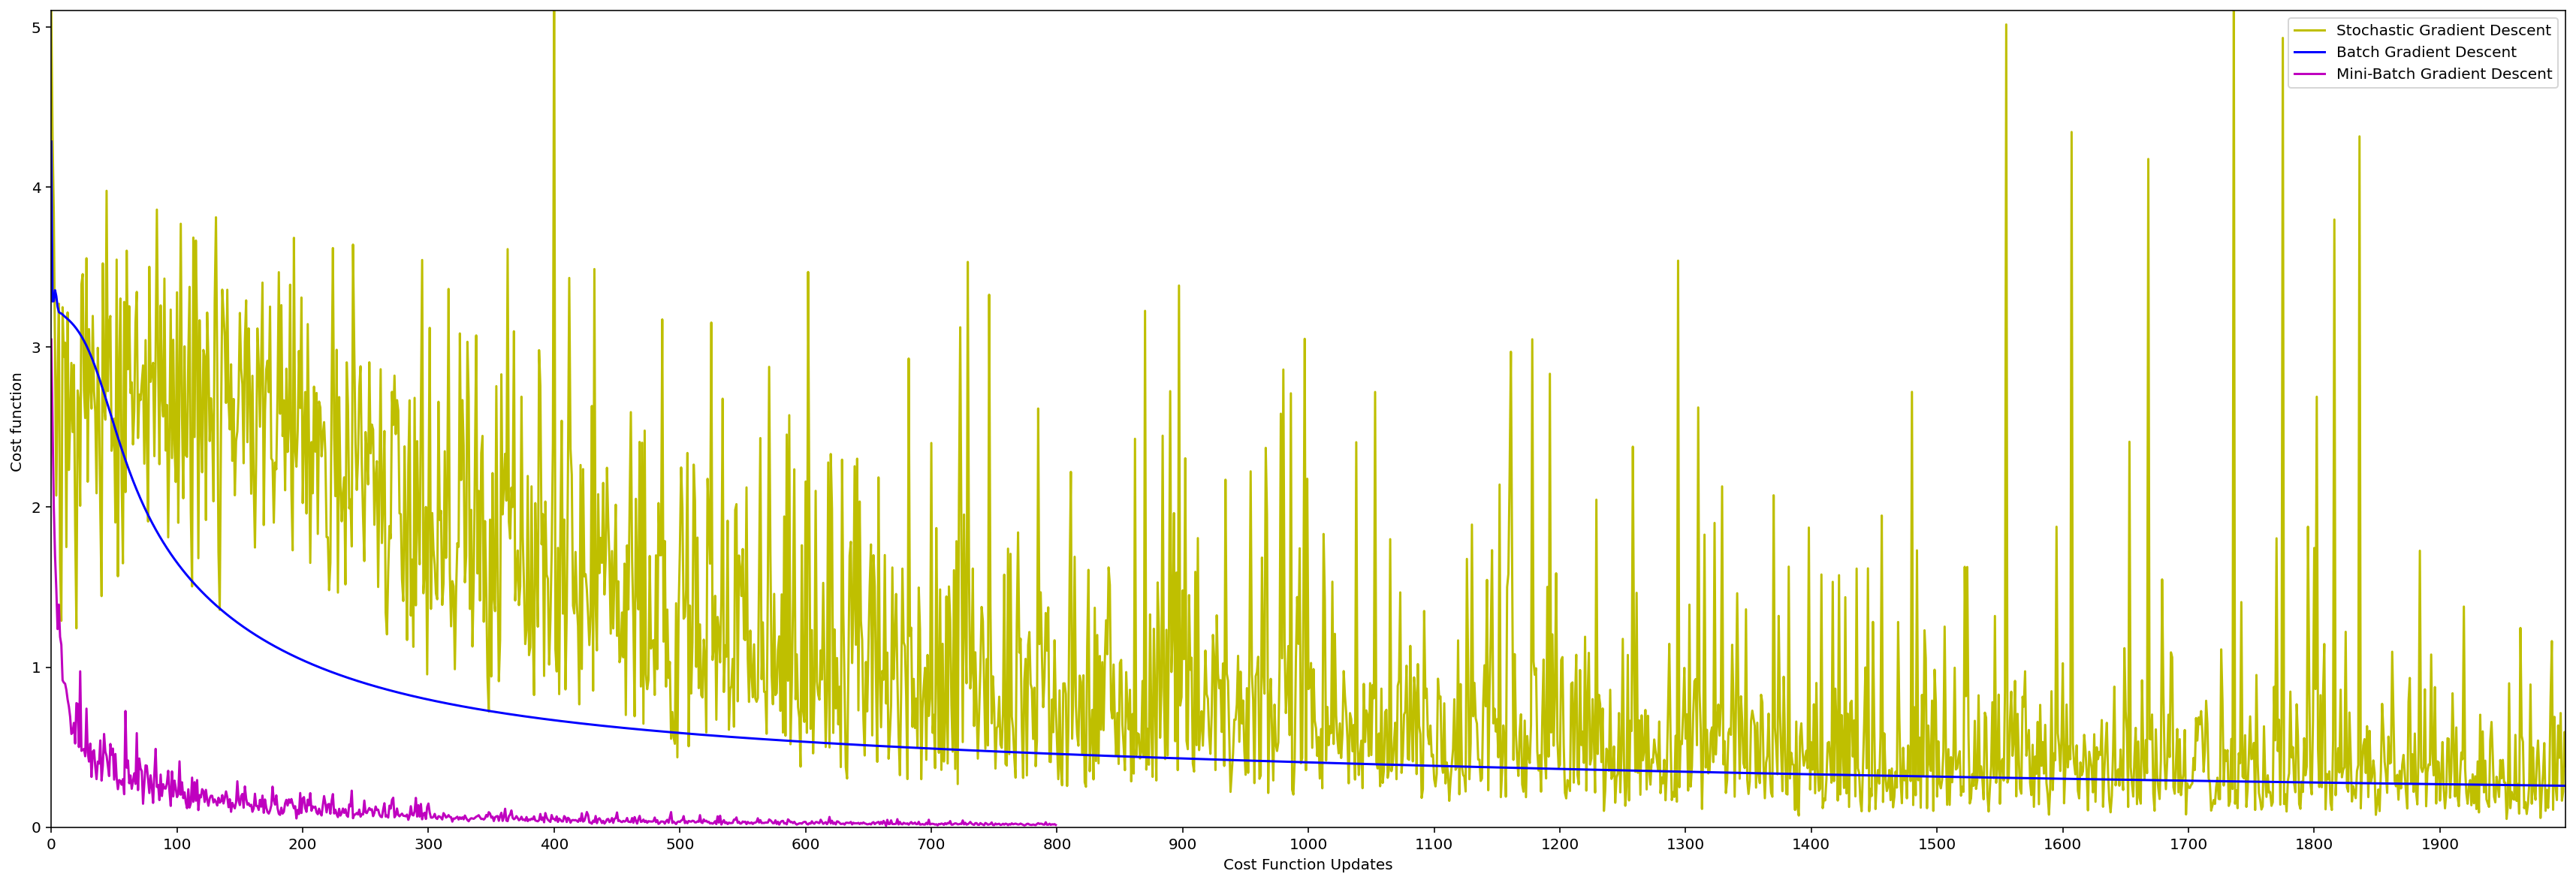

In [6]:
y_bound = max([BGD_mom[1][0],MBGD_mom[1][0],SGD_mom[1][0]])
plt.figure(figsize = (30,10))
plt.plot(SGD_mom[1],'y', label = 'Stochastic Gradient Descent')
plt.plot(BGD_mom[1], 'b', label = 'Batch Gradient Descent')
plt.plot(MBGD_mom[1], 'm', label = 'Mini-Batch Gradient Descent')
plt.xlabel('Cost Function Updates')
plt.ylabel('Cost function ')
plt.xticks(np.arange(0,2000,100))
plt.ylim([0,y_bound])
plt.xlim([0,2000])
plt.legend()